<a href="https://colab.research.google.com/github/jrbeduardo/covid-ltsm/blob/main/covid_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🧰 Librerías utilizadas y su propósito en el modelo

Para el desarrollo del modelo de predicción con redes LSTM, se utilizan las siguientes bibliotecas de Python, ampliamente usadas en ciencia de datos y aprendizaje automático:

---

#### 📊 `pandas`
- Uso: manipulación y análisis de datos tabulares.
- Aplicaciones en este proyecto:
  - Carga de archivos CSV
  - Transformación de datos (por ejemplo, convertir a formato largo con `melt`)
  - Agrupaciones y resúmenes por municipio y fecha

---

#### 🧮 `numpy`
- Uso: operaciones numéricas de alto rendimiento.
- Aplicaciones:
  - Manejo de arrays para crear secuencias de entrenamiento
  - Cálculo de métricas personalizadas o preprocesamiento de datos

---

#### 📈 `matplotlib` y `seaborn`
- Uso: visualización de datos.
- Aplicaciones:
  - Trazado de series temporales de casos reales y predichos
  - Gráficos de boxplot y distribución para análisis exploratorio (EDA)
  - Visualización del desempeño del modelo (errores, curvas de pérdida)

---

#### 🧪 `scikit-learn` (`sklearn`)
- Uso: herramientas de machine learning y estadísticas.
- Aplicaciones:
  - `StandardScaler`: normalización de los datos de entrada
  - `mean_absolute_percentage_error` y `mean_squared_error`: cálculo de métricas MAPE y RMSE

---

#### 🤖 `tensorflow.keras`
- Uso: creación y entrenamiento de redes neuronales profundas.
- Aplicaciones:
  - `Sequential`, `Input`, `LSTM`, `Bidirectional`, `Dense`: definición de la arquitectura del modelo LSTM
  - `EarlyStopping`: técnica para evitar sobreentrenamiento al detener el entrenamiento si no mejora la validación
  - `model.predict`: para realizar predicciones con el modelo entrenado

---

> Estas librerías proporcionan un entorno robusto para construir modelos predictivos eficientes, interpretar su desempeño y visualizar los resultados de forma clara.


In [46]:
# ========================================
# 📦 Carga de librerías
# ========================================

# Manipulación y análisis de datos
import pandas as pd           # Estructuras de datos tipo DataFrame
import numpy as np            # Cálculo numérico eficiente

# Visualización
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns            # Gráficos estadísticos más avanzados

# Preprocesamiento
from sklearn.preprocessing import StandardScaler  # Normalización de datos

# Métricas de evaluación
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Modelado con redes neuronales
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping  # Para detener entrenamiento si no mejora


### 🔁 ¿Qué es una red LSTM?

Las **LSTM** (*Long Short-Term Memory*) son un tipo especial de red neuronal recurrente (**RNN**) diseñadas para aprender patrones en **secuencias de datos** como series temporales, texto o audio.

---

### 🧠 ¿Por qué usar LSTM?

A diferencia de las redes neuronales tradicionales, las LSTM pueden **retener información durante muchas etapas de tiempo**, lo que las hace ideales para problemas donde los datos pasados afectan los resultados futuros, como:

- Casos diarios de COVID
- Pronóstico del clima
- Traducción automática
- Reconocimiento de voz

---

### 🧩 Estructura básica de una celda LSTM

Una celda LSTM contiene **puertas** que controlan el flujo de información:

1. **Puerta de olvido (`forget gate`)**: decide qué información antigua se descarta.
2. **Puerta de entrada (`input gate`)**: selecciona qué nueva información se guarda.
3. **Puerta de salida (`output gate`)**: determina qué parte del estado oculto se envía como salida.

Esta estructura permite a la red:
- **Recordar patrones importantes** a largo plazo
- **Olvidar ruido o valores irrelevantes**
- Evitar el problema del *gradiente desvanecido*, común en RNN tradicionales

---

### 🔄 ¿Qué es una LSTM Bidireccional?

Una **LSTM Bidireccional** procesa la secuencia **hacia adelante y hacia atrás**:

- Captura dependencias pasadas (como una LSTM normal)
- Y también dependencias futuras, dentro de la secuencia de entrada

Esto es útil cuando se tiene **toda la secuencia disponible** al momento del entrenamiento, como en análisis retrospectivos de series de datos.

---

### 📦 En resumen

| Característica      | LSTM tradicional | LSTM Bidireccional       |
|---------------------|------------------|---------------------------|
| Dirección de lectura| Adelante         | Adelante y atrás          |
| Capacidad de memoria| Alta             | Mayor (doble contexto)    |
| Casos de uso        | Series temporales, texto, audio | Igual, pero con mejores resultados cuando se tiene toda la secuencia disponible |

> En este proyecto, se usa una LSTM Bidireccional para predecir los casos diarios de COVID, capturando mejor los patrones locales y estacionales de la serie temporal.



## Funciones

In [45]:
def crear_ventanas(serie, n_pasos=30):
    """
    Crea ventanas deslizantes para series temporales.
    Args:
        serie: np.array (n, 1)
        n_pasos: int
    Returns:
        X, y: arrays para entrenamiento de modelos secuenciales
    """
    X, y = [], []
    for i in range(n_pasos, len(serie)):
        X.append(serie[i - n_pasos:i])
        y.append(serie[i])
    return np.array(X), np.array(y)

## Carga

In [2]:
 df = pd.read_csv('/content/Casos_Diarios_Municipio_Confirmados_20230625.csv')

In [20]:
df.columns[:4]

Index(['cve_ent', 'poblacion', 'nombre', '26-02-2020'], dtype='object')

In [23]:
df_long = pd.melt(df, id_vars=['cve_ent', 'poblacion', 'nombre'], var_name='fecha', value_name='casos')
df_long['fecha'] = pd.to_datetime(df_long['fecha'], dayfirst=True)
df_long.head()

,cve_ent,poblacion,nombre,fecha,casos
0,16046,15290,Juarez,2020-02-26,0
1,16047,22358,Jungapeo,2020-02-26,0
2,16048,5862,Lagunillas,2020-02-26,0
3,16049,18769,Madero,2020-02-26,0
4,5035,744247,Torreon,2020-02-26,0


## EDA

In [24]:
df_long.info()
df_long.describe(include='all')
df_long.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985255 entries, 0 to 2985254
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   cve_ent    int64         
 1   poblacion  int64         
 2   nombre     object        
 3   fecha      datetime64[ns]
 4   casos      int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 113.9+ MB


,0
cve_ent,0
poblacion,0
nombre,0
fecha,0
casos,0


In [25]:
print(f"Rango de fechas: {df_long['fecha'].min()} → {df_long['fecha'].max()}")
print(f"Número de municipios únicos: {df_long['nombre'].nunique()}")
print(f"Número total de registros: {df_long.shape[0]}")

Rango de fechas: 2020-02-26 00:00:00 → 2023-06-24 00:00:00
Número de municipios únicos: 2318
Número total de registros: 2985255


In [26]:
casos_totales = df_long.groupby('nombre')['casos'].sum().sort_values(ascending=False)
print("Top 10 municipios con más casos acumulados:")
print(casos_totales.head(10))

Top 10 municipios con más casos acumulados:
nombre
Iztapalapa           275879
Alvaro Obregon       243002
Gustavo A. Madero    233390
Tlalpan              188182
San Luis Potosi      157931
Benito Juarez        153889
Puebla               146151
Leon                 138982
Queretaro            126222
Monterrey            121301
Name: casos, dtype: int64


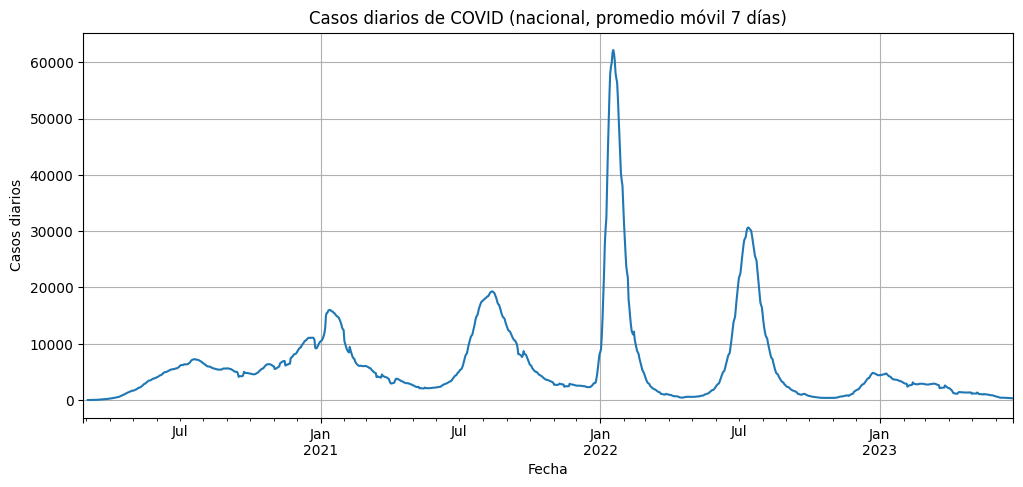

In [27]:
evolucion_nacional = df_long.groupby('fecha')['casos'].sum()

evolucion_nacional.rolling(7).mean().plot(figsize=(12,5), title='Casos diarios de COVID (nacional, promedio móvil 7 días)')
plt.xlabel("Fecha")
plt.ylabel("Casos diarios")
plt.grid(True)
plt.show()


In [28]:
casos_por_mpio = df_long.groupby(['nombre', 'poblacion'])['casos'].sum().reset_index()
casos_por_mpio['casos_por_100mil'] = casos_por_mpio['casos'] / casos_por_mpio['poblacion'] * 1e5

casos_por_mpio.sort_values(by='casos_por_100mil', ascending=False).head(10)


,nombre,poblacion,casos,casos_por_100mil
86,Alvaro Obregon,755537,242735,32127.480190
1026,Milpa Alta,139371,40357,28956.526107
2182,Tlalpan,682234,188182,27583.204590
200,Azcapotzalco,408441,106856,26161.918123
2168,Tlahuac,366586,91575,24980.495709
2376,Xochimilco,418060,99260,23743.003397
882,La Magdalena Contreras,245147,54096,22066.759944
161,Atizapan,12511,2633,21045.479978
887,La Paz,301961,62244,20613.258004
791,Iztacalco,393821,80089,20336.396485


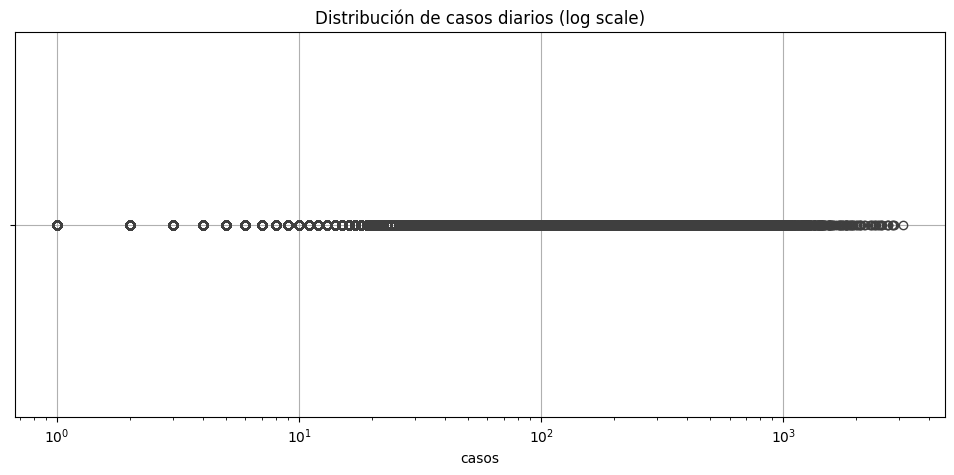

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df_long, x='casos')
plt.xscale('log')  # para ver mejor si hay picos grandes
plt.title("Distribución de casos diarios (log scale)")
plt.grid(True)
plt.show()


## Deeplearning

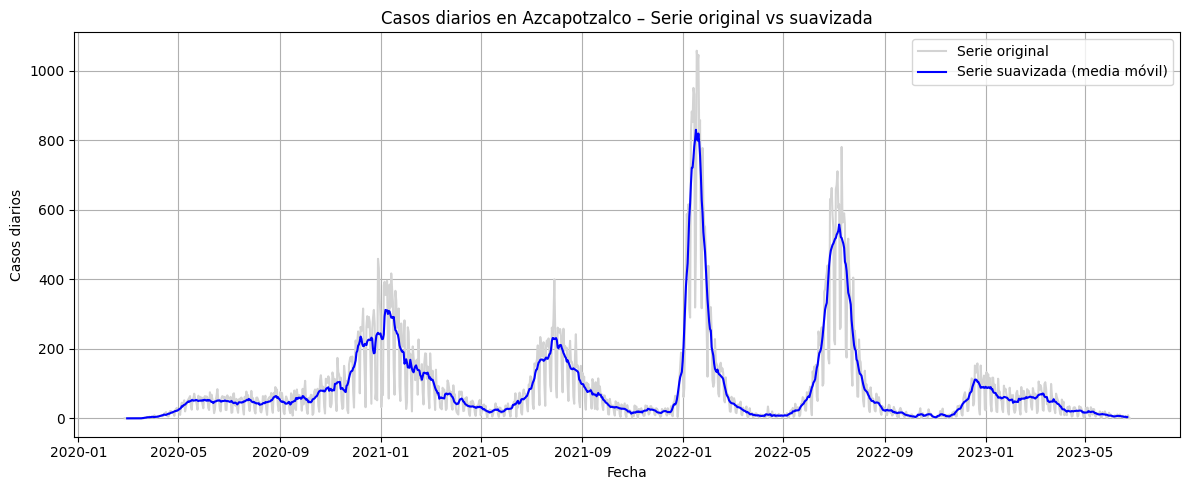

In [36]:

# Filtrar
municipio = 'Azcapotzalco'
serie = df_long[df_long['nombre'] == municipio].sort_values('fecha')

# Resetear índices
serie.reset_index(drop=True, inplace=True)
# Graficar serie original y suavizada
serie_suave = pd.Series(serie['casos']).rolling(window=7, center=True).mean()
plt.figure(figsize=(12, 5))
plt.plot(serie['fecha'], serie['casos'], label='Serie original', color='lightgray')
plt.plot(serie['fecha'], serie_suave, label='Serie suavizada (media móvil)', color='blue')

plt.title(f'Casos diarios en {municipio} – Serie original vs suavizada')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 🧮 ¿Por qué se elige `StandardScaler` en lugar de `MinMaxScaler`?

Al trabajar con series temporales y redes neuronales como LSTM, es importante normalizar la escala de los datos. Las dos opciones más comunes son:

---

#### ✅ `StandardScaler`
- Transforma los datos para que tengan **media 0** y **desviación estándar 1**.
- Fórmula:
  $$
  x_{\text{scaled}} = \frac{x - \mu}{\sigma}
  $$
- **Ventajas:**
  - Ideal para datos con **distribuciones centradas** o con **outliers moderados**.
  - Más **robusto que `MinMaxScaler`** cuando hay valores extremos.
  - Mejora la estabilidad y convergencia durante el entrenamiento del modelo.

---

#### ❌ `MinMaxScaler`
- Escala los datos al rango **[0, 1]**:
  $$
  x_{\text{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
  $$
- **Problema**: en presencia de **outliers grandes**, la mayoría de los valores quedan "aplastados" en un rango pequeño, afectando la señal de aprendizaje del modelo.

---

### 📌 Conclusión
> En este proyecto se utiliza `StandardScaler` porque los casos diarios de COVID presentan valores variables y algunos outliers. Esta técnica preserva mejor la estructura interna de los datos sin ser distorsionada por extremos.


In [37]:
serie_suave_limpia = serie_suave.dropna().values.reshape(-1, 1)  # reshaping para usar con StandardScaler

# Escalar la serie suavizada
scaler = StandardScaler()
serie_norm = scaler.fit_transform(serie_suave_limpia)

## Division

In [38]:
# Crear ventanas
n_pasos = 30
X, y = crear_ventanas(serie_norm, n_pasos)

# Tamaños de conjunto
total = len(X)
train_size = int(total * 0.7)
val_size = int(total * 0.15)
test_size = total - train_size - val_size  # el resto

# División sin barajar
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test   = X[train_size + val_size:], y[train_size + val_size:]
print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

Train: (825, 30, 1)
Val: (176, 30, 1)
Test: (178, 30, 1)


### 🧠 Arquitectura del modelo LSTM utilizado

Este modelo utiliza una red neuronal basada en **LSTM (Long Short-Term Memory)** para predecir series temporales de casos diarios de COVID-19. Se entrena con secuencias de los últimos *n* días para predecir el siguiente valor (o varios futuros, si se usa predicción multi-step).

## 🧩 Capas del modelo:
- Input Layer

  - Forma: (n_pasos, 1)

  - Cada muestra es una secuencia de n_pasos días, con 1 feature (casos diarios).

- Bidirectional LSTM

  - 64 unidades ocultas

  - Usa activación ReLU (relu)

  - Procesa la secuencia en ambas direcciones (adelante y atrás), lo cual ayuda a capturar patrones más ricos en series que tienen dependencia simétrica o retardos.

- Dense Layer

  - Una capa totalmente conectada con 1 neurona de salida

  - Produce una predicción escalar (casos del siguiente día)

## ⚙️ Hiperparámetros relevantes
- n_pasos: 30 (días usados como entrada)

- activation: 'relu' en lugar de 'tanh' por rendimiento observado en este dataset

- optimizer: 'adam'

- loss: 'mse' (error cuadrático medio)

## ✅ Justificación del uso de LSTM Bidireccional
La LSTM tradicional procesa la secuencia de forma unidireccional (de t₁ a tₙ). La LSTM bidireccional procesa la secuencia en ambos sentidos, lo que:

- Mejora el aprendizaje de patrones simétricos o recurrentes.

- Es útil cuando toda la secuencia de entrada está disponible y no se requiere inferencia en tiempo real.



In [39]:
# ========================================
model = Sequential([
    Input(shape=(n_pasos, 1)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(1)
])

model.summary()

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

##  Entrenamiento

In [40]:
# ========================================
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.6637 - val_loss: 0.0615
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0440 - val_loss: 0.0299
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0277 - val_loss: 0.0111
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0157 - val_loss: 0.0132
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0221 - val_loss: 0.0110
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0129 - val_loss: 0.0182
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0118 - val_loss: 0.0133
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0125 - val_loss: 0.0127
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0106 - val_loss: 0.0197
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

# Predicción y métricas

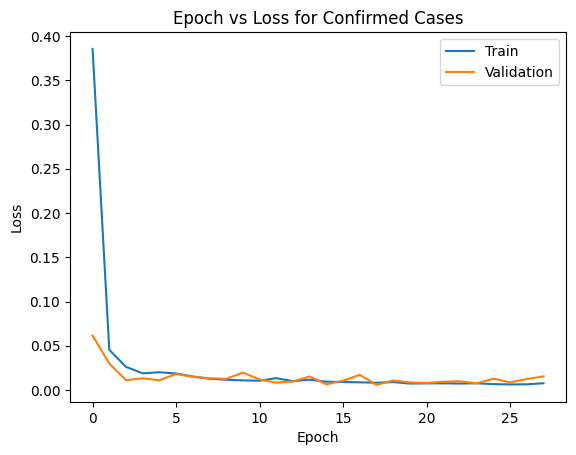

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### 📏 Métricas de evaluación: MAPE y RMSE

Para evaluar el rendimiento del modelo de predicción de series temporales, se utilizan dos métricas complementarias: **MAPE** (Error Porcentual Absoluto Medio) y **RMSE** (Raíz del Error Cuadrático Medio).

---

#### 📊 1. MAPE – Mean Absolute Percentage Error

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

- Mide el **porcentaje de error absoluto medio** entre la predicción y el valor real.
- **Ventaja**: Intuitivo y fácil de interpretar como porcentaje de error.
- **Desventaja**: Se vuelve inestable si hay valores reales cercanos a 0.
- En este notebook se aplica una **máscara para excluir valores reales menores a 10** para evitar distorsiones.

---

#### 📐 2. RMSE – Root Mean Square Error

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

- Mide el error en las mismas unidades que la variable objetivo (casos diarios).
- Penaliza más fuertemente los **errores grandes**.
- Permite comparar directamente con el número real de casos.

---

### ✅ Interpretación práctica

- **MAPE bajo** indica que el modelo predice correctamente en **términos relativos** (porcentaje del valor real).
- **RMSE bajo** indica que el modelo tiene buen desempeño en **valores absolutos**.

---

> Ambas métricas se complementan: mientras el MAPE da una idea del error proporcional, el RMSE muestra cuánto se desvía la predicción en términos reales.


In [42]:
# Predicción
y_pred = model.predict(X_test)

# Desescalar
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Máscara: excluir valores reales muy pequeños (ej. menores a 10)
mask = y_test_inv.flatten() > 10

# Cálculo de métricas
mape = mean_absolute_percentage_error(y_test_inv[mask], y_pred_inv[mask])
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAPE (sin ceros): {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
MAPE (sin ceros): 0.10
RMSE: 5.14


## Visualización

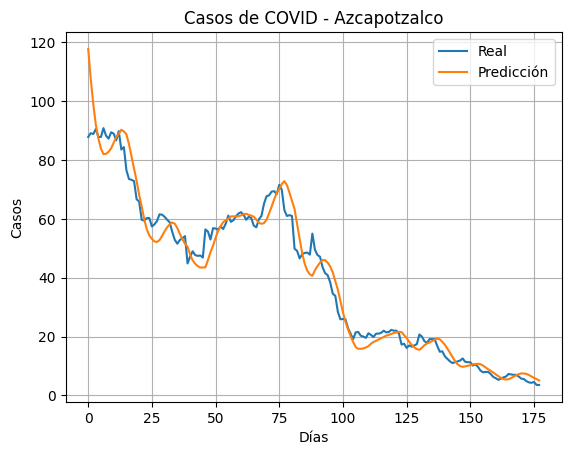

In [43]:
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predicción')
plt.title(f'Casos de COVID - {municipio}')
plt.xlabel('Días')
plt.ylabel('Casos')
plt.legend()
plt.grid(True)
plt.show()

### 📊 esultados

Después de entrenar y evaluar el modelo LSTM, se obtuvieron las siguientes métricas de desempeño en el conjunto de prueba:

- **MAPE (sin ceros)**: 0.10 → **10 %**
- **RMSE**: 5.14 casos

---

### ✅ ¿Qué significan?

#### 📈 MAPE = 0.10 (10 %)

- En promedio, el modelo comete un **error del 10 %** respecto al valor real de los casos diarios (sin contar días con valores muy bajos).
- Es un resultado **muy bueno** en contextos epidemiológicos, donde fluctuaciones pequeñas pueden ser comunes.
- Este bajo porcentaje sugiere que el modelo **aprendió bien los patrones** de la serie temporal y tiene buena generalización.

#### 📉 RMSE = 5.14

- La predicción tiene una desviación promedio de **aproximadamente 5 casos diarios** con respecto al valor real.
- Dado que los casos diarios pueden variar entre 10 y más de 100 (según el municipio), este error es **relativamente bajo en escala absoluta**.
- Indica que las predicciones no sólo son precisas en porcentaje, sino también **cercanas a los valores reales en unidades concretas**.

---

### 📌 Conclusión

> El modelo tiene un **muy buen rendimiento** tanto en términos **relativos** como **absolutos**, lo que lo hace adecuado para aplicaciones prácticas como vigilancia epidémica, predicción de brotes locales o apoyo a decisiones sanitarias.

Este desempeño también sugiere que el **preprocesamiento (suavizado, normalización)** y la **arquitectura elegida (LSTM Bidireccional)** están bien alineados con la naturaleza del problema.
